ML Final Project

Spring 2017 - NYU CUSP

Notebook reads in datetime converted CitiBike Data by month (e.g. Jan_citi.csv) from 2016 and converts gets the counts and means per month

Written in Python 2.7 (Anaconda)

In [2]:
import numpy as np
import pandas as pd
import geopandas as gp
from geopandas import GeoDataFrame
import os
import io
import subprocess
from shapely.geometry import Point
from datetime import datetime
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
from datetime import datetime
import matplotlib.pyplot as plt
import sklearn
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score as rs
from sklearn import svm, datasets
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import IsolationForest
from pandas.tseries.holiday import USFederalHolidayCalendar
from mpl_toolkits.mplot3d import Axes3D

from itertools import compress

np.random.seed(222)

%matplotlib inline
%pylab inline
pd.options.display.max_columns = 120
pd.options.display.max_rows = 120

Populating the interactive namespace from numpy and matplotlib


/Users/geoffperrin/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
`%matplotlib` prevents importing * from pylab and numpy


In [3]:
proj_folder = os.getcwd()

Check for spurious entires

## Remove spurious trip length rationale

From website: A $101 security deposit hold will be placed on your card when you purchase a pass. If you incur usage

fees, your card will be charged. The fee for a lost or stolen bike is $1200 (+ tax).


## Total Loss: 

Annual pass = 163/year + 101 Security fee + ($ 2.50 * min) = 5616 minutes
 
3 day Pass = 24 + 101 Security fee + ($ 2.50 * 15min) = 4031.25

Day Pass = 12 + 101 Security fee + ($4 * 15min) = 4076.25

Ride = 4 + 101 Security fee + ($4 * 15min) = 4106.25 

So remove anything longer than 5616 minutes, the maximum time before Total Loss and keep trip long than 1 minute

In [27]:

def citi_agg_stat_day(label):
    '''This function is supposed to: Further clean citi bike data, Group by day, 
    get daily count and mean and then export the files to prepare for a large merge'''
    #Import the csv
    getfile = "data/" + label + ".csv"
    citi_agg = pd.read_csv(getfile)
    #Drop column
    #citi_agg.drop('Unnamed: 0', axis=1, inplace=True)
    #change seconds to minutes
    citi_agg['tripduration'] = citi_agg['tripduration'].apply(lambda x: x / 60)
    #Remove spurious trips
    citi_agg = citi_agg[(citi_agg.tripduration > 1) & (citi_agg.tripduration < 5616)]
    #DatTime again??
    citi_agg['starttime'] = pd.to_datetime(citi_agg['starttime'])
    citi_agg['stoptime'] = pd.to_datetime(citi_agg['stoptime'])
    #Count Trips per day 
    citi_agg['bike_date'] = citi_agg['starttime'].dt.date
    citi_day_count = citi_agg.groupby(['bike_date'], as_index=False)['tripduration'].count()
    citi_day_count.columns = ['bike_date', 'bike_trip_count']
    
    #take the mean of the taxi stats each day
    citi_stat_agg = citi_agg.groupby(['bike_date'], as_index=False).mean()
    
    #Merge the seperate DataFrames 
    citi_df_by_day = citi_stat_agg.merge(citi_day_count, on='bike_date')
    
    #Get the weekday
    citi_df_by_day['weekday'] = 0
    for i in range(len(citi_df_by_day)):
        citi_df_by_day['weekday'].iloc[i] = citi_df_by_day.bike_date.iloc[i].weekday()
        
    #Export to csv
    output = "data/" + label + "_df_by_day.csv"
    citi_df_by_day.to_csv(output)
    #citi_df_byday_all
    return citi_df_by_day 

In [57]:
def citi_daystation_count(label):
    '''This function is supposed to: Further clean citi bike data, do some grouping
    and calculations and then export the files to prepare for a large merge'''
    #Import the csv
    getfile1 = "data/" + label + ".csv"
    citi_agg1 = pd.read_csv(getfile1)
    #Drop column
    #citi_agg1.drop('Unnamed: 0', axis=1, inplace=True)
    #change seconds to minutes
    citi_agg1['tripduration'] = citi_agg1['tripduration'].apply(lambda x: x / 60)
    #Remove spurious trips
    citi_agg1 = citi_agg1[(citi_agg1.tripduration > 1) & (citi_agg1.tripduration < 5616)]
    #DatTime again??
    citi_agg1['starttime'] = pd.to_datetime(citi_agg1['starttime'])
    citi_agg1['stoptime'] = pd.to_datetime(citi_agg1['stoptime'])
    #citi_agg['day_number'] = label.starttime.apply(lambda x: x.hour)
    citi_agg1['bike_date'] = citi_agg1['starttime'].dt.date
    
    
    #Count Trips per day 
    citi_agg1['bike_date'] = citi_agg1['starttime'].dt.date
    citi_day_count1 = citi_agg1.groupby(['bike_date', "start station id"], as_index=False)['tripduration'].count()
    citi_day_count1.columns = ['bike_date', "start station id",'bike_trip_count']
    return citi_day_count1 

## Aggregate by day and Export

In [46]:
columns =['bike_date', 'tripduration', 'start station id', 'start station latitude', 'start station longitude', \
          'end station id', 'end station latitude','end station longitude', 'bikeid', 'birth year', \
          'gender', 'start_hour', 'end_hour','bike_trip_count', 'weekday']

In [47]:
months = ["Jan_citi", "Feb_citi", "Mar_citi", "Apr_citi", "May_citi", "Jun_citi", "Jul_citi", "Aug_citi", \
          "Sep_citi", "Oct_citi", "Nov_citi", "Dec_citi"]

In [48]:
months2 = ["citibike_201501", "citibike_201502", "citibike_201503", "citibike_201504", "citibike_201505", \
          "citibike_201506", "citibike_201507", "citibike_201508", "citibike_201509", "citibike_201510", \
          "citibike_201511", "citibike_201512"]

In [49]:
#Create Empty dataframe
#citi_df_all_day = pd.read_csv(io.StringIO(None), names=columns, dtype=dict(zip(columns,[object, float, float, float, float, float, float, float, float, float, float, float, float, int, int])))

In [50]:
# Create the files in bulk
# By day with count and mean
for i in (months2):
    #x = citi_agg_stat_day(str(i))
    #citi_df_all_day = citi_df_all_day.append(x, ignore_index = True)
        

In [51]:
#citi_df_all_day.to_csv('data/citi_df_all_day.csv')

In [1]:
#citi_df_all_day.head()

NameError: name 'citi_df_all_day' is not defined

In [4]:
citi_df_all_day = pd.read_csv('data/citi_df_all_day.csv')

## Grouping by station and time of day

In [53]:
months = ["Jan_citi", "Feb_citi", "Mar_citi", "Apr_citi", "May_citi", "Jun_citi", "Jul_citi", "Aug_citi", \
          "Sep_citi", "Oct_citi", "Nov_citi", "Dec_citi"]

In [54]:
columns2 =['bike_date', 'start station id', 'bike_trip_count', 'birth year', \
          'gender', 'start_hour', 'end_hour', 'weekday']

In [55]:
#citi_day_by_station = pd.read_csv(io.StringIO(None), names=columns2, dtype=dict(zip(columns,[object, int, int])))

In [58]:
#Get Station count grouped by day
for i in (months2):
    #y = citi_daystation_count(str(i))
    #citi_day_by_station = citi_day_by_station.append(y, ignore_index = True)

In [59]:
#citi_day_by_station.to_csv('data/citi_day_by_station.csv')

### Add holiday / day of week / weekend features

In [10]:
cal = USFederalHolidayCalendar()
holidays = cal.holidays('2012', '2016', return_name=True)
holidays.name = 'name'
holidays.head()

2012-01-02                 New Years Day
2012-01-16    Dr. Martin Luther King Jr.
2012-02-20                Presidents Day
2012-05-28                   MemorialDay
2012-07-04                      July 4th
Name: name, dtype: object

In [11]:
holidays_all = pd.concat([holidays,
                         "Day Before " + holidays.shift(-1, 'D'),
                         "Day After " + holidays.shift(1, 'D')])
holidays_all = holidays_all.sort_index()

In [12]:
citi_df_all_day['bike_date'] = pd.to_datetime(citi_df_all_day['bike_date'])

In [13]:
#add holiday dummy variable
citi_df_all_day['holiday'] = 0
citi_df_all_day['holiday'][citi_df_all_day['bike_date'].isin(holidays_all.index.date)] = 1

/Users/geoffperrin/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [14]:
citi_df_all_day.head()

,Unnamed: 0,bike_date,bike_trip_count,bikeid,birth year,end station id,end station latitude,end station longitude,end_hour,gender,start station id,start station latitude,start station longitude,start_hour,tripduration,weekday,holiday
0,0,2015-01-01,5232,18228.704320,1975.853424,436.648318,40.731650,-73.990431,NaN,1.074924,444.357989,40.731981,-73.990203,NaN,13.061735,3,1
1,1,2015-01-02,11183,18115.172494,1974.899753,448.722346,40.735134,-73.990541,NaN,1.135116,457.012698,40.735489,-73.990242,NaN,11.813467,4,1
2,2,2015-01-03,4419,18138.598099,1975.253756,437.654673,40.732972,-73.991073,NaN,1.181036,440.649468,40.732796,-73.990320,NaN,10.559855,5,0
3,3,2015-01-04,7767,18143.683662,1976.204934,433.743788,40.732547,-73.991111,NaN,1.169821,441.868933,40.732899,-73.991071,NaN,10.936526,6,0
4,4,2015-01-05,14332,18162.715392,1974.299468,444.383338,40.736732,-73.990462,NaN,1.153921,443.429249,40.736996,-73.990238,NaN,10.245255,0,0


In [15]:
citi_df_all_day['day_of_week'] = citi_df_all_day.bike_date.apply(lambda x: x.weekday())

In [17]:
#control for Friday / Saturday nights
citi_df_all_day['weekend'] = 0
citi_df_all_day['weekend'][(citi_df_all_day['day_of_week'] == 4) | (citi_df_all_day['day_of_week'] == 5)] = 1

/Users/geoffperrin/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


## Clustering Anomaly Detection

### K-means Anomaly Detection

In [18]:
cluster_features = ['bike_trip_count', 'holiday', 'weekend']

In [19]:
X = citi_df_all_day[cluster_features]
X.head(2)

,bike_trip_count,holiday,weekend
0,5232,1,0
1,11183,1,1


In [20]:
#normalize columns
for i in X.columns:
    X[i] = (X[i] - X[i].mean()) / X[i].std()
    
X.head()

/Users/geoffperrin/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


,bike_trip_count,holiday,weekend
0,-1.626679,3.337076,-0.630377
1,-1.180955,3.337076,1.582005
2,-1.687572,-0.298843,1.582005
3,-1.436810,-0.298843,-0.630377
4,-0.945098,-0.298843,-0.630377


In [21]:
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for n_clusters in range_n_clusters:
    km = KMeans(n_clusters=n_clusters, random_state=324)
    cluster_labels = km.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters ={},".format(n_clusters)+" the average silhouette_score is :{}".format(silhouette_avg))

For n_clusters =2, the average silhouette_score is :0.581226697855
For n_clusters =3, the average silhouette_score is :0.564541494399
For n_clusters =4, the average silhouette_score is :0.601355240731
For n_clusters =5, the average silhouette_score is :0.646677398384
For n_clusters =6, the average silhouette_score is :0.603819988197
For n_clusters =7, the average silhouette_score is :0.597415252311
For n_clusters =8, the average silhouette_score is :0.61339505491


In [22]:
n=5
KM=KMeans(n_clusters=n,random_state=999)
scor=KM.fit_predict(X)

res=pd.DataFrame(KM.transform(X))
res=pd.concat((res,pd.DataFrame(KM.fit_predict(X))),axis=1)
res.columns=list(range(n))+["cluster"]
res.loc[:,"score"]=res.apply(lambda x: x[int(x["cluster"])],axis=1)

In [23]:
citi_df_all_day['cluster'] = res.cluster
citi_df_all_day['km_score'] = res.score
citi_df_all_day['outlier'] = 0
citi_df_all_day.sort_values("km_score",ascending=False, inplace=True)

In [24]:
citi_df_all_day.head(3)

,Unnamed: 0,bike_date,bike_trip_count,bikeid,birth year,end station id,end station latitude,end station longitude,end_hour,gender,start station id,start station latitude,start station longitude,start_hour,tripduration,weekday,holiday,day_of_week,weekend,cluster,km_score,outlier
1,1,2015-01-02,11183,18115.172494,1974.899753,448.722346,40.735134,-73.990541,NaN,1.135116,457.012698,40.735489,-73.990242,NaN,11.813467,4,1,4,1,1,1.983058,0
285,285,2015-10-13,48581,20415.005496,1976.805125,806.217739,40.738160,-73.987590,NaN,1.107285,819.792182,40.738462,-73.987552,NaN,15.807908,1,1,1,0,1,1.957344,0
358,358,2015-12-25,12188,20216.492123,1974.496808,1055.435510,40.740225,-73.986536,NaN,0.664588,1066.382097,40.740249,-73.986321,NaN,30.319905,4,1,4,1,1,1.950265,0


In [25]:
citi_df_all_day['outlier'][:10] = 1 

/Users/geoffperrin/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [26]:
def set_color(Data1):
    if (Data1.outlier == 1):
        return "red"
    elif (Data1.cluster == 0):
        return "blue"
    elif (Data1.cluster == 1):
        return "cyan"
    else:
        return "green"

citi_df_all_day = citi_df_all_day.assign(color=citi_df_all_day.apply(set_color, axis=1))

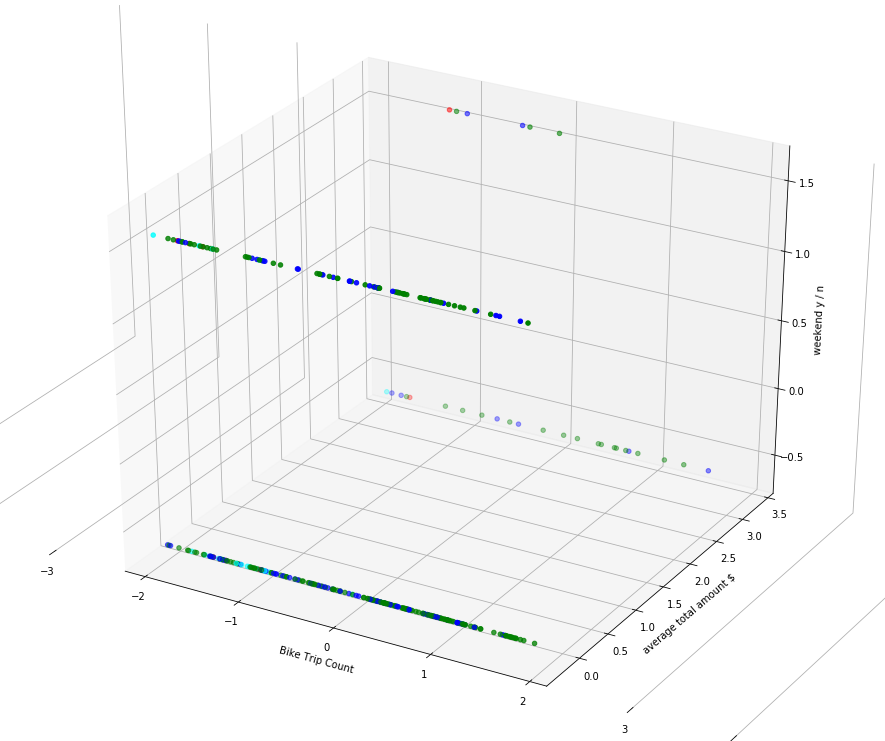

In [28]:
fig = plt.figure(figsize=(12,10))
ax = Axes3D(fig)

ax.scatter(X.bike_trip_count, X.holiday, X.weekend, c=citi_df_all_day.color)
ax.set_xlabel('Bike Trip Count')
ax.set_ylabel('average total amount $')
ax.set_zlabel('weekend y / n')
# set x ticks and labels
ax.set_xticks(range(-5, 5, 1))
# change fontsize
for t in ax.zaxis.get_major_ticks(): t.label.set_fontsize(10)
plt.show()

## Isolation Anomaly Detection

### Isolation Forest Anomaly Detection

In [30]:
train,test=train_test_split(X, random_state=999, test_size=0.3)
# fit the model
clf = IsolationForest(max_samples=100, random_state=999)
clf.fit(train)
y_pred = clf.predict(X)

In [31]:
citi_df_all_day['decision_function'] = clf.decision_function(X)

In [32]:
citi_df_all_day.sort_values(by='decision_function').head(10)

,Unnamed: 0,bike_date,bike_trip_count,bikeid,birth year,end station id,end station latitude,end station longitude,end_hour,gender,start station id,start station latitude,start station longitude,start_hour,tripduration,weekday,holiday,day_of_week,weekend,cluster,km_score,outlier,color,decision_function
285,285,2015-10-13,48581,20415.005496,1976.805125,806.217739,40.738160,-73.987590,NaN,1.107285,819.792182,40.738462,-73.987552,NaN,15.807908,1,1,1,0,1,1.957344,1,red,-0.172983
162,162,2015-06-12,34786,18098.419680,1975.926367,456.634106,40.734825,-73.991504,NaN,1.080636,459.777468,40.735064,-73.991317,NaN,14.011729,4,0,4,1,2,0.010828,0,green,-0.172281
4,4,2015-01-05,14332,18162.715392,1974.299468,444.383338,40.736732,-73.990462,NaN,1.153921,443.429249,40.736996,-73.990238,NaN,10.245255,0,0,0,0,0,0.009789,0,blue,-0.167288
315,315,2015-11-12,36862,20327.557024,1976.741738,816.056400,40.737822,-73.987452,NaN,1.163854,838.007759,40.738062,-73.987224,NaN,13.000515,3,1,3,0,1,1.120040,0,cyan,-0.166081
220,220,2015-08-09,32395,19815.767032,1978.174897,493.488193,40.732449,-73.992169,NaN,0.854854,494.455008,40.732737,-73.992027,NaN,22.888563,6,0,6,0,3,0.396496,0,green,-0.152145
318,318,2015-11-15,25666,20575.289917,1978.014851,916.872867,40.736590,-73.986514,NaN,1.075314,920.398114,40.736882,-73.986297,NaN,17.378672,6,0,6,0,0,0.839117,0,blue,-0.151626
274,274,2015-10-02,9297,20817.391847,1977.003258,713.122405,40.737188,-73.987381,NaN,1.137356,739.535657,40.737576,-73.986749,NaN,15.985587,4,0,4,1,4,0.068884,0,green,-0.149475
101,101,2015-04-12,19746,18044.428087,1977.717207,439.569736,40.732226,-73.991502,NaN,1.001469,435.772004,40.732498,-73.991439,NaN,18.103363,6,0,6,0,0,0.395715,0,blue,-0.148392
185,185,2015-07-05,25657,18546.319445,1977.023377,479.901625,40.732642,-73.991865,NaN,0.806057,476.956425,40.732933,-73.991807,NaN,19.665199,6,0,6,0,0,0.838443,0,blue,-0.137942
306,306,2015-11-03,48845,20211.402150,1976.525139,847.936452,40.738517,-73.987521,NaN,1.096120,868.522551,40.738825,-73.987369,NaN,15.649831,1,0,1,0,3,0.835593,0,green,-0.131416


## Look at specific areas and see what times / dates around there are anomalies
### Madison Square Gardens (40.750556, -73.993611)

In [ ]:
latlon_list = [40.750556, -73.993611]
#only keep trips within a reasonable pickup lat / lon (without converting geometries)
citi_df_total_subset = citi_day_by_station[(citi_day_by_station.start_station_latitude > (latlon_list[0] - 0.005)) & (citi_day_by_station.start_station_latitude < (latlon_list[0] + 0.005))]
citi_df_total_subset = citi_df_total_subset[(citi_df_total_subset.start_station_longitude > (latlon_list[1] - 0.005)) & (citi_df_total_subset.start_station_longitude < (latlon_list[1] + 0.005))]

In [ ]:
# convert to geopandas df
geometry = [Point(xy) for xy in zip(citi_df_total_subset.start_station_longitude, citi_df_total_subset.start_station_latitude)]

In [ ]:
crs = {'init': 'epsg:4326'}
citi_df_total_subset = GeoDataFrame(citi_df_total_subset, crs=crs, geometry=geometry)

In [ ]:
# create MSG buffer 
d = {'latitude': latlon_list[0], 'longitude': latlon_list[1]}
MSG = pd.DataFrame(data=d, index=[0])
geometry_MSG = [Point(xy) for xy in zip(MSG.longitude, MSG.latitude)]
crs = {'init': 'epsg:4326'}
MSG_gp = GeoDataFrame(crs=crs, geometry=geometry_MSG)

In [ ]:
#create buffer
MSG_gp['geometry'] = MSG_gp.geometry.buffer(.005)
MSG_gp.head()

In [ ]:
# only keep points within MSG buffer
citi_df_total_subset = citi_df_total_subset[citi_df_total_subset.geometry.intersects(MSG_gp.geometry[0])]

In [ ]:
citi_df_total_subset['hour'] = citi_df_total_subset.tpep_pickup_datetime.apply(lambda x: x.hour)

In [ ]:
#subset to 3pm - midnight hours (to only capture relevant hours)
#tlc_df_total_gp_subset = tlc_df_total_gp_subset[(tlc_df_total_gp_subset.hour >= 15) & (tlc_df_total_gp_subset.hour <= 23)]

In [ ]:
#take the mean of the taxi stats each day / hour
citi_df_MSG_mean = citi_df_total_subset.groupby(['taxi_date'], as_index=False).mean()
citi_df_MSG_mean.head()

In [ ]:
citi_df_MSG_mean['day_of_week'] = citi_df_MSG_mean.taxi_date.apply(lambda x: x.weekday())

In [ ]:
#control for Friday / Saturday nights
citi_df_MSG_mean['weekend'] = 0
citi_df_MSG_mean['weekend'][(citi_df_MSG_mean['day_of_week'] == 4) | (citi_df_MSG_mean['day_of_week'] == 5)] = 1

In [ ]:
#add holiday dummy variable
citi_df_MSG_mean['holiday'] = 0
citi_df_MSG_mean['holiday'][citi_df_MSG_mean['taxi_date'].isin(holidays_all.index.date)] = 1

In [ ]:
# read in NYC street shapefile
'''
shapefile taken from https://geo.nyu.edu/catalog/nyu_2451_34565

'''
ny_streets_raw = gp.read_file(proj_folder + '/data/nyu_2451_34565/nyu_2451_34565.shp')
ny_streets_raw = ny_streets_raw.to_crs(epsg=4326)
# only keep points within MSG buffer
ny_streets = ny_streets_raw[ny_streets_raw.geometry.intersects(MSG_gp.geometry[0])]

In [ ]:
# is there a way to easily plot each color differently? I have this color column highlighting outliers!

MSG_sample = citi_df_MSG_mean.sample(n=1000)
#MSG_sample.lon = MSG_sample.geometry.x
#MSG_sample.lat = MSG_sample.geometry.y
f, (ax1) = plt.subplots(figsize=(12,8))
MSG_sample.plot(alpha=0.5, ax=ax1, color = 'red')
ny_streets['geometry'].plot(alpha=1, linewidth=0.25, ax=ax1, color = '0')
ax1.set_title("Plot of Taxi Pickups, Around MSG", fontsize=20)
plt.xlabel("longitude")
plt.ylabel("latitude")

## MSG anomaly analysis (isolation forest)

In [ ]:
X = tlc_df_total_gp_subset[cluster_features]
X.head(2)

In [ ]:
#normalize columns
for i in X.columns:
    X[i] = (X[i] - X[i].mean()) / X[i].std()

In [ ]:
train,test=train_test_split(X, random_state=999, test_size=0.3)
# fit the model
clf = IsolationForest(max_samples=100, random_state=999)
clf.fit(train)
y_pred = clf.predict(X)

In [ ]:
citi_df_total_subset['decision_function'] = clf.decision_function(X)

In [ ]:
citi_df_total_subset.sort_values(by='decision_function').head(10)

### K-Means Cluster Model Anomaly Detection

In [ ]:
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for n_clusters in range_n_clusters:
    km = KMeans(n_clusters=n_clusters, random_state=324)
    cluster_labels = km.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters ={},".format(n_clusters)+" the average silhouette_score is :{}".format(silhouette_avg))

In [ ]:
n=3
KM=KMeans(n_clusters=n,random_state=999)
scor=KM.fit_predict(X)

res=pd.DataFrame(KM.transform(X))
res=pd.concat((res,pd.DataFrame(KM.fit_predict(X))),axis=1)
res.columns=list(range(n))+["cluster"]
res.loc[:,"score"]=res.apply(lambda x: x[int(x["cluster"])],axis=1)

In [ ]:
citi_df_total_subset['cluster'] = res.cluster
citi_df_total_subset['km_score'] = res.score
citi_df_total_subset['outlier'] = 0
citi_df_total_subset.sort_values("km_score",ascending=False, inplace=True)

In [ ]:
citi_df_total_subset['outlier'][:10] = 1 

In [ ]:
def set_color(Data1):
    if (Data1.outlier == 1):
        return "red"
    elif (Data1.cluster == 0):
        return "blue"
    elif (Data1.cluster == 1):
        return "cyan"
    else:
        return "green"

citi_df_total_subset = citi_df_total_subset.assign(color=citi_df_total_subset.apply(set_color, axis=1))

In [ ]:
fig = plt.figure(figsize=(12,10))
ax = Axes3D(fig)

ax.scatter(X.taxi_trip_count, X.total_amount, X.weekend, c=citi_df_total_subset.color)
ax.set_xlabel('Taxi Trip Count')
ax.set_ylabel('average total amount $')
ax.set_zlabel('weekend y / n')
# set x ticks and labels
ax.set_xticks(range(-5, 5, 1))
# change fontsize
for t in ax.zaxis.get_major_ticks(): t.label.set_fontsize(10)
plt.show()